# Missing data and anomalous data.

Let's start by importing the libraries we are going to use.

In [154]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from ydata_profiling import ProfileReport

## Quick dataframe analysis

We import our file as a dataframe, correct the types if there are errors and check.

In [237]:
path_parquet = os.path.join('..','data', 'interim', 'Ensanut-data.parquet')
df = pd.read_parquet(path_parquet)
df['Sexo'] = df['Sexo'].astype('category')  # Convertir a categoría
df.dtypes

Folio                                   object
Edad                                     int64
Sexo                                  category
C_Entidad                                int64
Entidad                                 object
Fecha                           datetime64[ns]
Atentar_contras_si                    category
Depresion                             category
Tristeza                              category
Cuantos cigarrillos (numero)             Int64
Frecuencia emborrachar                category
dtype: object

Let's make a describe of our data.

In [238]:
df.describe()

,Edad,C_Entidad,Fecha,Cuantos cigarrillos (numero)
count,318268.000000,318268.000000,318260,61912.0
mean,34.854434,16.538911,2011-06-06 12:24:23.256457216,27.409549
min,10.000000,1.000000,1973-02-01 00:00:00,0.0
25%,17.000000,9.000000,2006-07-31 00:00:00,2.0
50%,32.000000,16.000000,2012-07-31 00:00:00,5.0
75%,48.000000,24.000000,2018-07-31 00:00:00,88.0
max,999.000000,32.000000,2023-11-23 00:00:00,999.0
std,20.984034,9.058555,NaN,40.640967


We can see that in the Edad and Fecha columns there are anomalies in the data.

Now we will see in which columns we have missing data.

In [239]:
# Contar los valores perdidos en cada columna
valores_perdidos = df.isna().sum()

# Filtrar y mostrar solo las columnas que tienen datos perdidos
columnas_con_perdidos = valores_perdidos[valores_perdidos > 0]
print("Columnas con datos perdidos:")
print(columnas_con_perdidos)

Columnas con datos perdidos:
Fecha                                8
Atentar_contras_si              166350
Depresion                       170513
Tristeza                        125272
Cuantos cigarrillos (numero)    256356
Frecuencia emborrachar          145415
dtype: int64


As we can see, there is a lot of missing data.

Since most variables are categorical, let's see how many "keys" there are for each column.

In [240]:
valores_unicos = df.nunique() # Contar valores únicos en cada columna

print(valores_unicos) # Mostrar el resultado

Folio                           196525
Edad                               103
Sexo                                 2
C_Entidad                           32
Entidad                             32
Fecha                              709
Atentar_contras_si                   7
Depresion                            8
Tristeza                             9
Cuantos cigarrillos (numero)        66
Frecuencia emborrachar              44
dtype: int64


We notice that there are more unique data per column than the data dictionary tells us so we'll need to fix this.

Let's first make some charts to help us visualize our scenario.

Let's start by seeing if there are any outliers in the "Edad" column.

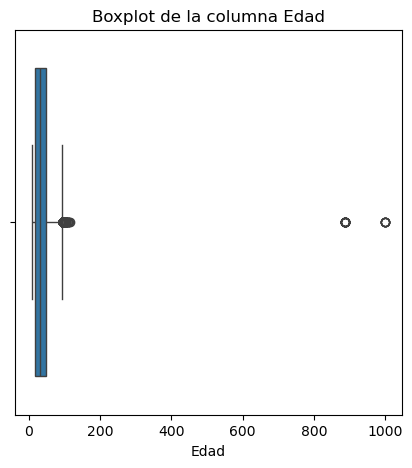

In [241]:
# Boxplot para la columna "Edad"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Edad'])
plt.title('Boxplot de la columna Edad')
plt.xlabel('Edad')
plt.show()

Let's see what happens with the column "Cuantos cigarrillos (numero)"

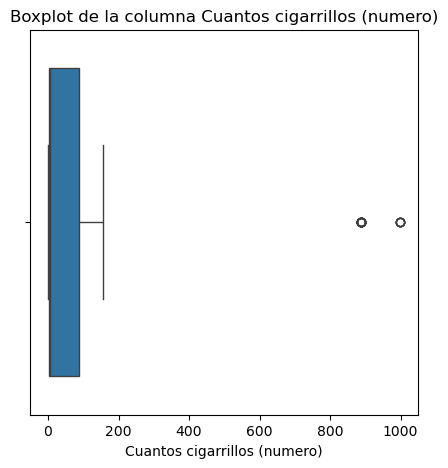

In [242]:
# Boxplot para la columna "Cuantos cigarrillos (numero)"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Cuantos cigarrillos (numero)'])
plt.title('Boxplot de la columna Cuantos cigarrillos (numero)')
plt.xlabel('Cuantos cigarrillos (numero)')
plt.show()

Let's now see what categories are in each of our categorical columns.

Let's start with "Atentar_contras_si"

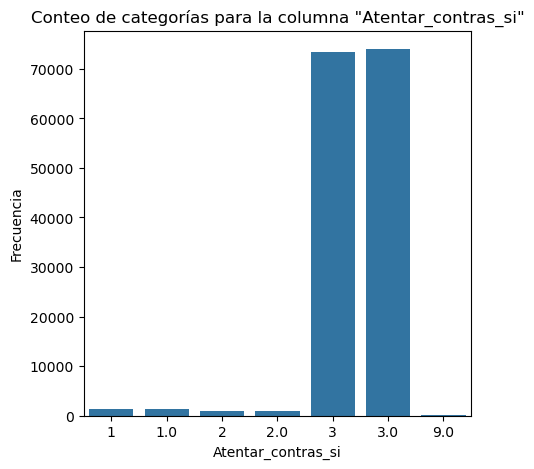

In [243]:
# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Atentar_contras_si')
plt.title('Conteo de categorías para la columna "Atentar_contras_si"')
plt.xlabel('Atentar_contras_si')
plt.ylabel('Frecuencia')
plt.show()

Let's see what happens with "Depresion"                          

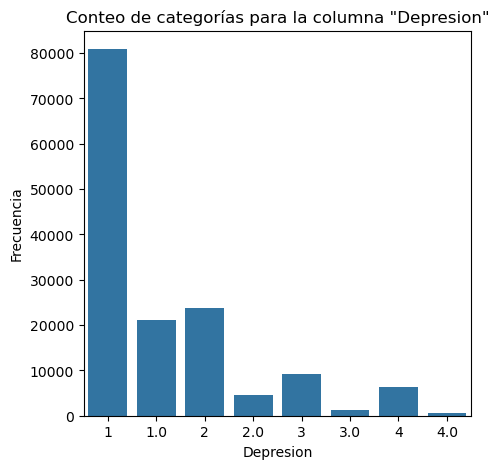

In [244]:
# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Depresion')
plt.title('Conteo de categorías para la columna "Depresion"')
plt.xlabel('Depresion')
plt.ylabel('Frecuencia')
plt.show()

We can also analyze what happens with "Tristeza"

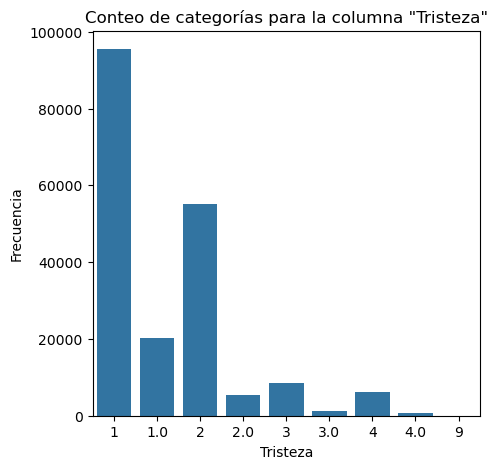

In [245]:
# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Tristeza')
plt.title('Conteo de categorías para la columna "Tristeza"')
plt.xlabel('Tristeza')
plt.ylabel('Frecuencia')
plt.show()

Finally, let's analyze what happens with "Frecuencia emborrachar "

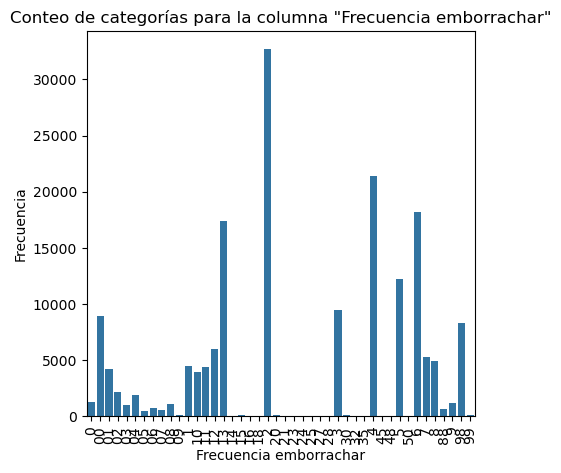

In [246]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Frecuencia emborrachar')
plt.title('Conteo de categorías para la columna "Frecuencia emborrachar"')
plt.xlabel('Frecuencia emborrachar')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

Finally, let's make a heatmap to see the missing values ​​of the dataframe.

<Axes: >

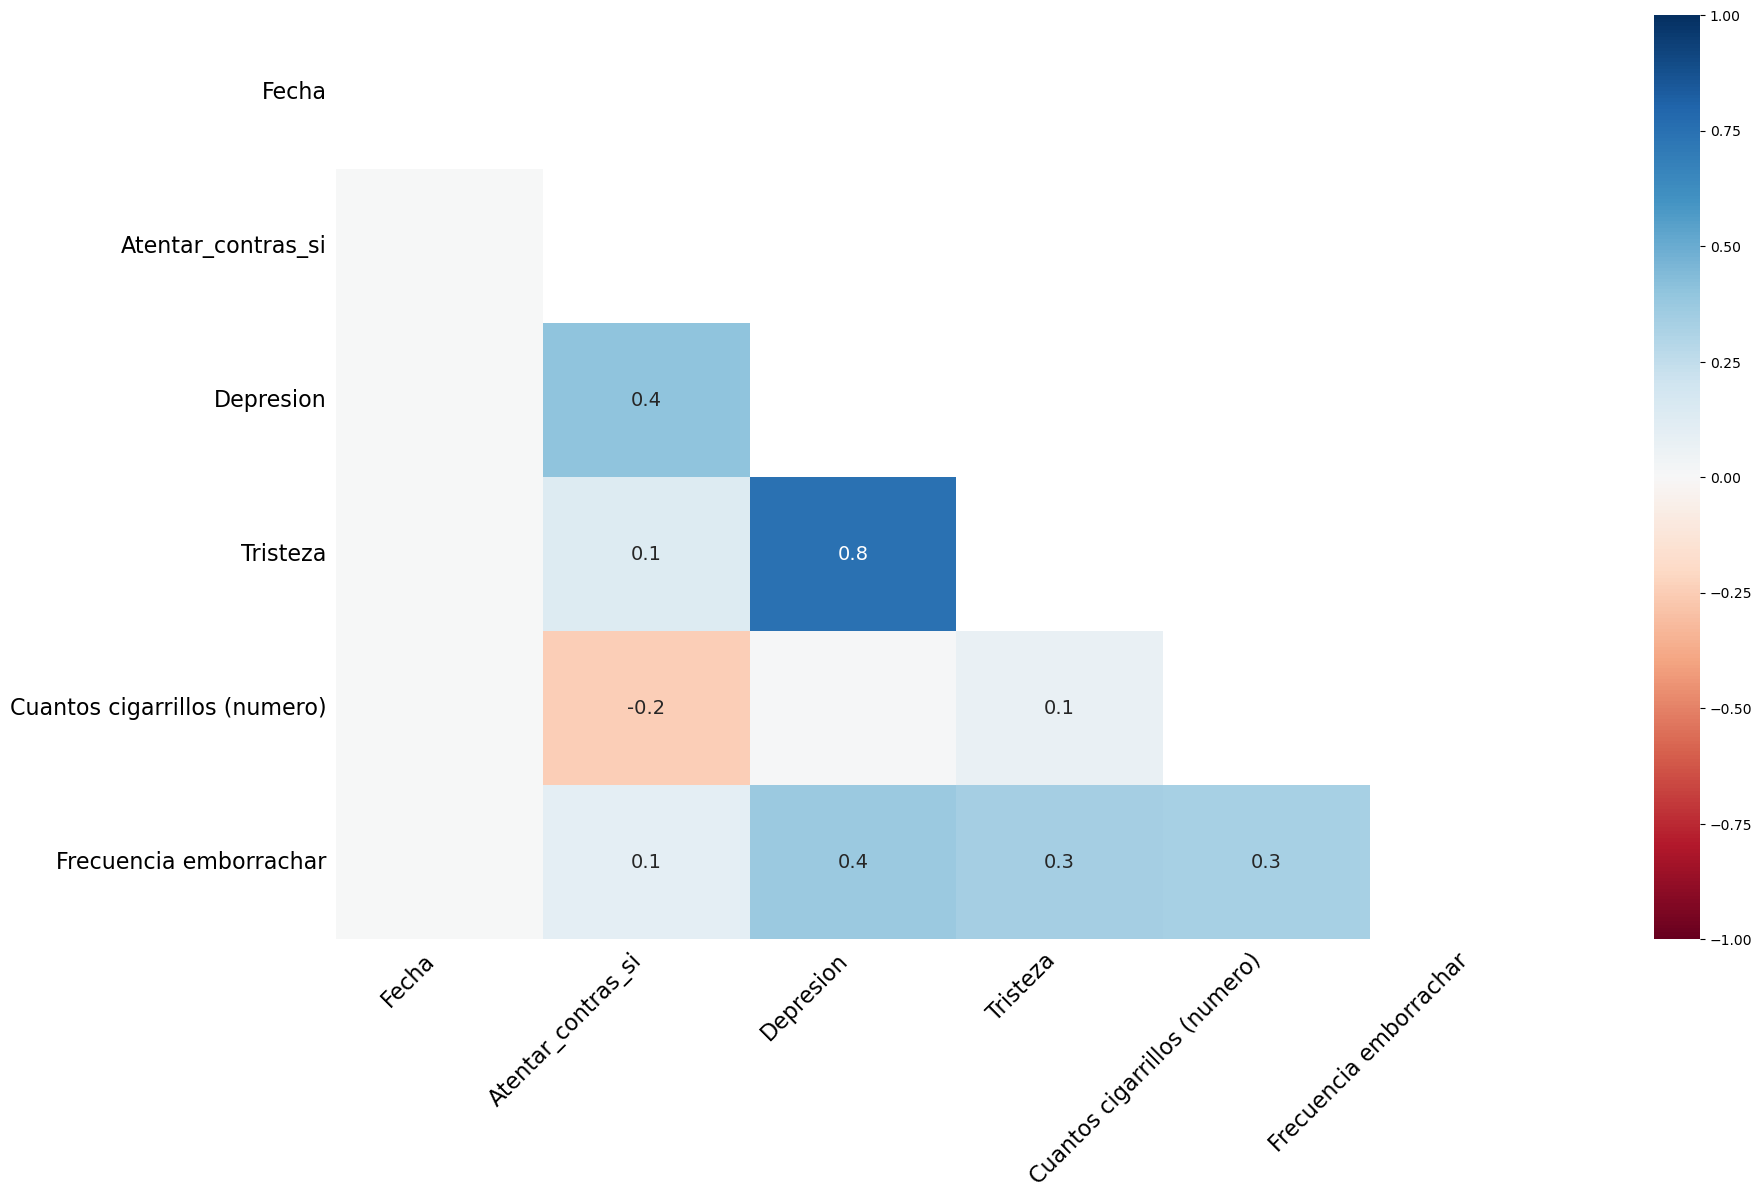

In [247]:
# Heatmap de valores perdidos para el DataFrame completo
msno.heatmap(df)

We can also visualize what the dataframe looks like with respect to the missing data.

<Axes: >

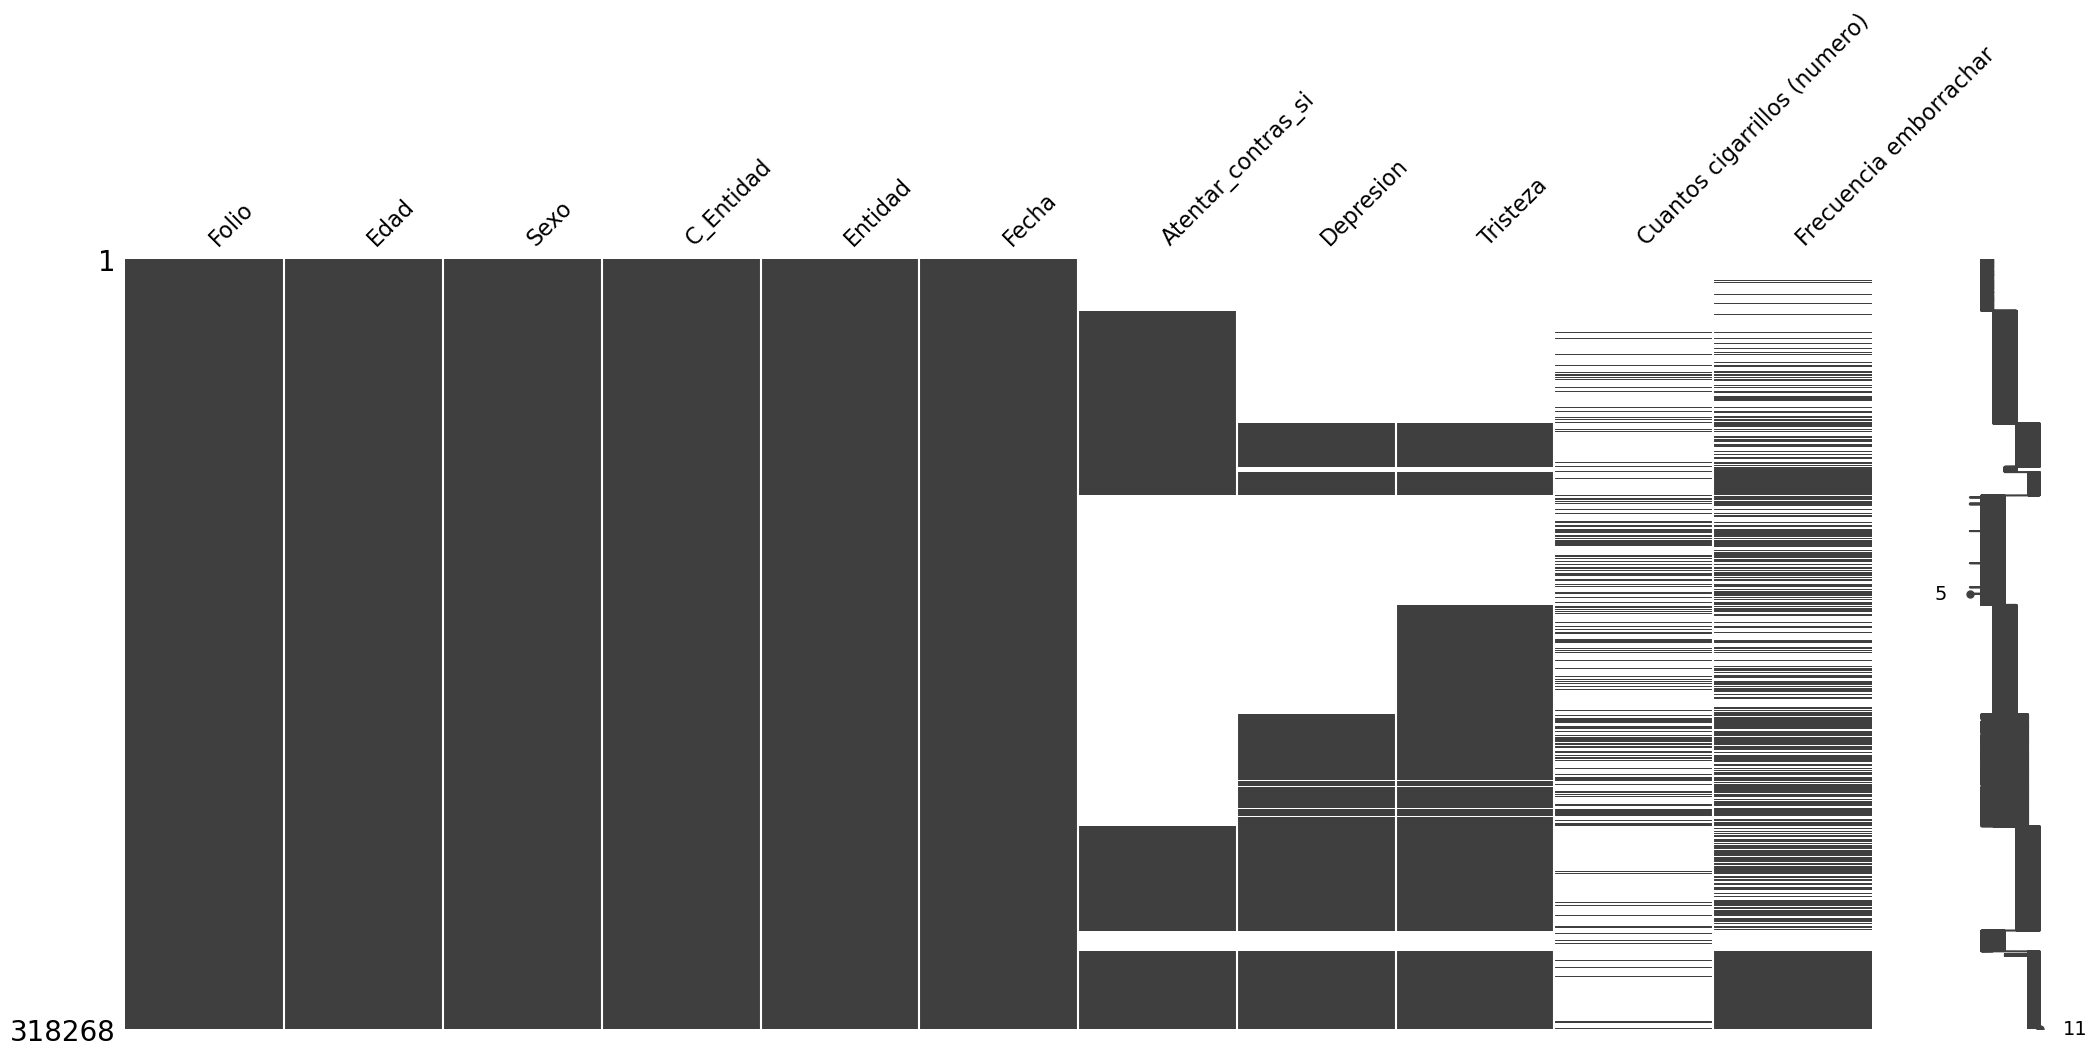

In [248]:
msno.matrix(df)

Finally, let's look at a bar chart to visualize how much missing data there is in the columns compared to others.

<Axes: >

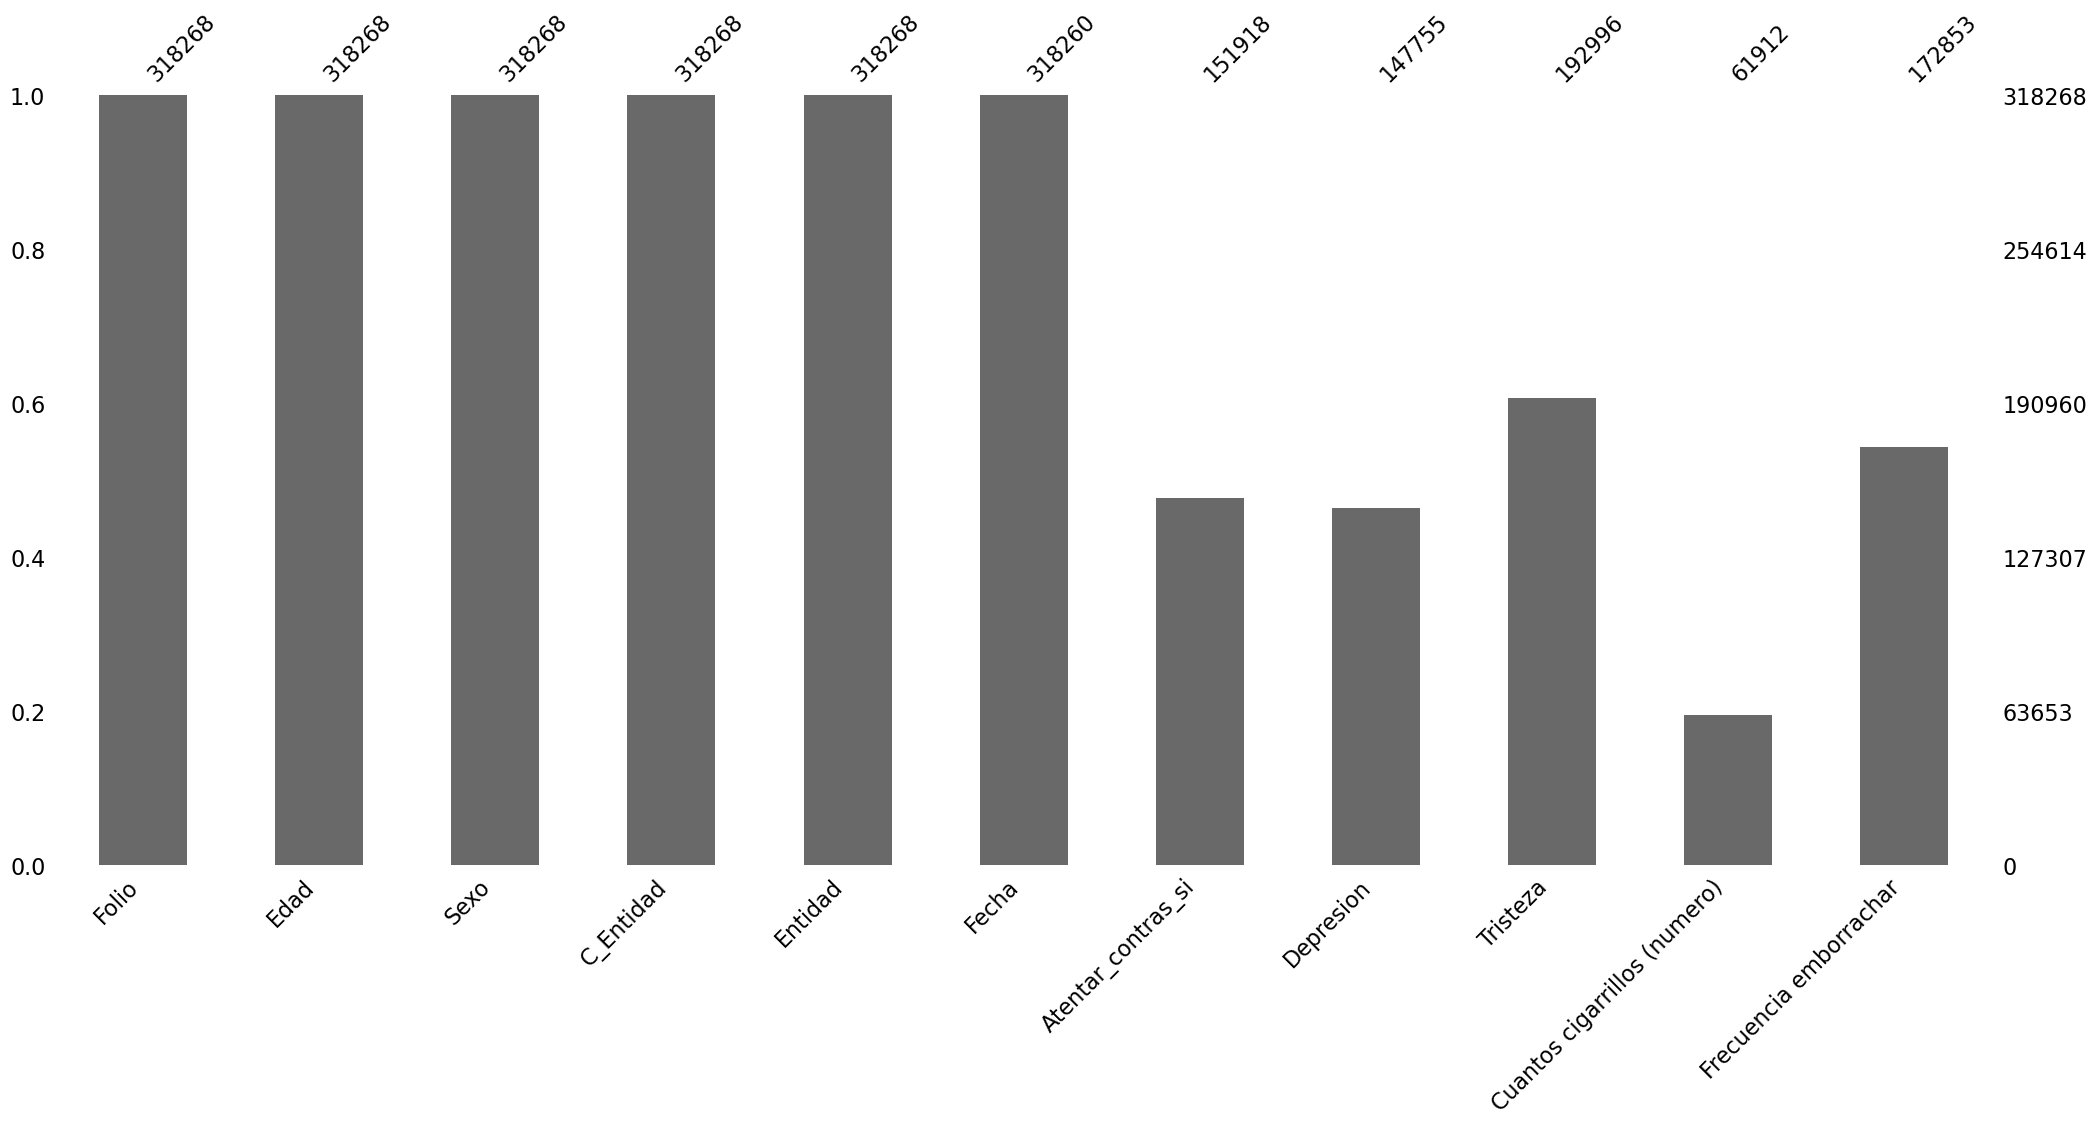

In [249]:
msno.bar(df)

## Outliers

Next we will make a quick criterion to remove some outliers values, since in the describe there are minimums and maximums that are not allowed in the numerical columns.

In [250]:
#Date
df.loc[(df['Fecha'].dt.year < 1999) | (df['Fecha'].dt.year > 2024), 'Fecha'] = np.nan
#Age
df.loc[(df['Edad'] < 0) | (df['Edad'] > 120), 'Edad'] = np.nan
#cigarrete number
df.loc[(df['Cuantos cigarrillos (numero)'] == 999) | (df['Cuantos cigarrillos (numero)'] == 88) | (df['Cuantos cigarrillos (numero)'] == 888), 'Cuantos cigarrillos (numero)'] = np.nan
#drunk frequency
df.loc[(df['Frecuencia emborrachar'] == '99') | (df['Frecuencia emborrachar'] == '88') | (df['Frecuencia emborrachar'] == '98'), 'Frecuencia emborrachar'] = np.nan

We do the same with the categorical columns.

In [251]:
def replace_numeric_categories(df, column, replacements):
    # Convierte la columna a tipo string
    df[column] = df[column].astype(str)
    # Reemplaza los valores de acuerdo al diccionario de reemplazo
    df[column] = df[column].replace(replacements)
    # Convierte la columna de nuevo a tipo categórico
    df[column] = df[column].astype('category')

# Diccionarios de reemplazo para cada columna
replacements_atentar = {'1.0': '1', '2.0': '2', '3.0': '3', '9.0': '9'}
replacements_depresion = {'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4'}
replacements_tristeza = {'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4', '9.0': '9'}
replacements_frecuencia_emborrachar = {'00':'0','01': '1', '02': '2', '03': '3', '04': '4','05':'5','06': '6', '07': '7', '08': '8', '9': '8', '09':'8', '10':'2','11': '2', '12': '2', '13': '2', '14': '2','15':'2','16': '2', '18': '2', '20': '3', '21':'3', '23':'3', '24':'3', '25':'3', '27':'3', '28':'3', '30':'4', '32':'4', '35':'4', '45':'5', '48':'5', '50':'6'}


# Aplica la función a cada columna
replace_numeric_categories(df, 'Atentar_contras_si', replacements_atentar)
replace_numeric_categories(df, 'Depresion', replacements_depresion)
replace_numeric_categories(df, 'Tristeza', replacements_tristeza)
replace_numeric_categories(df, 'Frecuencia emborrachar', replacements_frecuencia_emborrachar)



df.loc[df['Atentar_contras_si'] == 'nan', 'Atentar_contras_si'] = np.nan
df.loc[df['Depresion'] == 'nan', 'Depresion'] = np.nan
df.loc[df['Tristeza'] == 'nan', 'Tristeza'] = np.nan
df.loc[df['Frecuencia emborrachar'] == 'nan', 'Frecuencia emborrachar'] = np.nan

df['Atentar_contras_si'] = df['Atentar_contras_si'].cat.remove_categories('nan')
df['Depresion'] = df['Depresion'].cat.remove_categories('nan')
df['Tristeza'] = df['Tristeza'].cat.remove_categories('nan')
df['Frecuencia emborrachar'] = df['Frecuencia emborrachar'].cat.remove_categories('nan')

We make the same graphs showing that there are no longer any outliers.

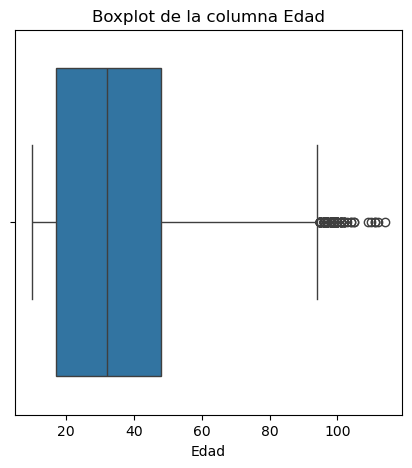

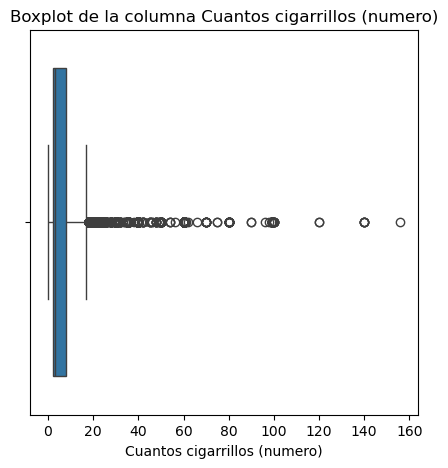

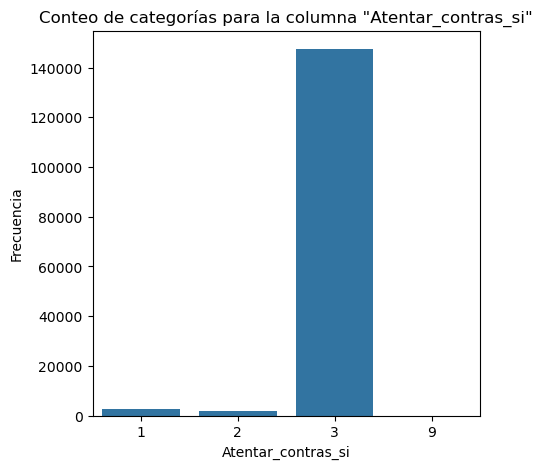

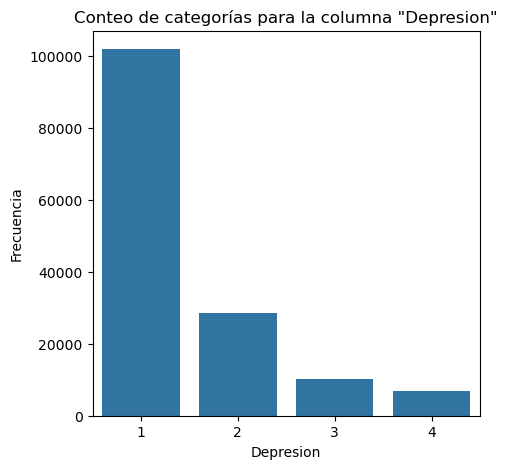

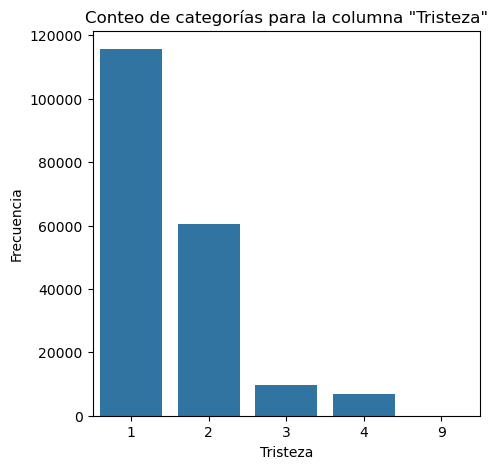

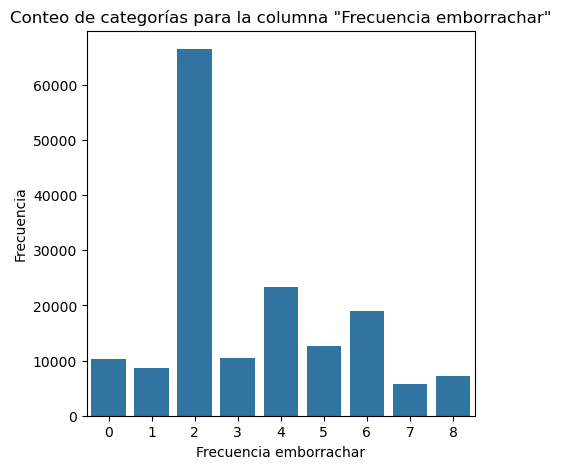

In [252]:
# Boxplot para la columna "Edad"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Edad'])
plt.title('Boxplot de la columna Edad')
plt.xlabel('Edad')
plt.show()

# Boxplot para la columna "Cuantos cigarrillos (numero)"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Cuantos cigarrillos (numero)'])
plt.title('Boxplot de la columna Cuantos cigarrillos (numero)')
plt.xlabel('Cuantos cigarrillos (numero)')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Atentar_contras_si')
plt.title('Conteo de categorías para la columna "Atentar_contras_si"')
plt.xlabel('Atentar_contras_si')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Depresion')
plt.title('Conteo de categorías para la columna "Depresion"')
plt.xlabel('Depresion')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Tristeza')
plt.title('Conteo de categorías para la columna "Tristeza"')
plt.xlabel('Tristeza')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Frecuencia emborrachar')
plt.title('Conteo de categorías para la columna "Frecuencia emborrachar"')
plt.xlabel('Frecuencia emborrachar')
plt.ylabel('Frecuencia')
plt.show()

We save our data in the corresponding folder.

In [253]:
path_save = os.path.join('..','data', 'interim', 'Ensanut-data-types.csv')
path_save_parquet = os.path.join('..','data', 'interim', 'Ensanut-data-types.parquet')
df.to_csv(path_save, index=False)
df.to_parquet(path_save_parquet)

## Missing data

We will now see a way to remove the missing data.

We start by loading the dataframe:

In [265]:
path_save_parquet = os.path.join('..','data', 'interim', 'Ensanut-data-types.parquet')
# Cargar datos
df = pd.read_parquet(path_save_parquet)

We change the data type to a convenient one and print information about our dataframe:

In [266]:
# Convertir la columna Fecha a datetime y Sexo a categórico
df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
df['Sexo'] = df['Sexo'].astype('category')
# Verificar nuevamente la información después de la conversión
data_info_post_conversion = df.info()
data_info_post_conversion


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318268 entries, 0 to 318267
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Folio                         318268 non-null  object        
 1   Edad                          318243 non-null  float64       
 2   Sexo                          318268 non-null  category      
 3   C_Entidad                     318268 non-null  int64         
 4   Entidad                       318268 non-null  object        
 5   Fecha                         318253 non-null  datetime64[ns]
 6   Atentar_contras_si            151918 non-null  category      
 7   Depresion                     147755 non-null  category      
 8   Tristeza                      192996 non-null  category      
 9   Cuantos cigarrillos (numero)  46464 non-null   Int64         
 10  Frecuencia emborrachar        163883 non-null  category      
dtypes: Int64(1), 

We use the IterativeImputer imputation method with a maximum of 10 iterations and set a seed, also the imputed columns are added as new columns to the dataframe:

In [268]:
# Seleccionar las columnas para la imputación
columns_to_impute = ['Edad', 'Atentar_contras_si', 'Depresion', 'Tristeza', 
                     'Cuantos cigarrillos (numero)', 'Frecuencia emborrachar']
data_impute = df[columns_to_impute]

# Configurar el IterativeImputer para manejar datos faltantes
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
data_imputed = pd.DataFrame(iterative_imputer.fit_transform(data_impute), columns=columns_to_impute)

# Añadir las columnas imputadas al DataFrame original con el sufijo '_ii'
for col in columns_to_impute:
    df[f"{col}_ii"] = data_imputed[col]

# Rellenar hacia adelante o hacia atrás
df['Fecha_ii'] = df['Fecha'].ffill()

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Since we now have real and non-categorical data, we have to adjust the limits of the previous categories:

In [269]:
# Reemplazar valores negativos en la columna 'Cuantos cigarrillos (numero)_ii' con 0
df['Cuantos cigarrillos (numero)_ii'] = df['Cuantos cigarrillos (numero)_ii'].clip(lower=0)

# Redondear y convertir las columnas categóricas, limitando los valores entre 0 y 9
df['Depresion_ii'] = df['Depresion_ii'].round().clip(1, 4).astype('category')
df['Frecuencia emborrachar_ii'] = df['Frecuencia emborrachar_ii'].round().clip(0, 8).astype('category')



categorical_columns = ['Atentar_contras_si_ii', 'Tristeza_ii']
for col in categorical_columns:
    # Redondear los valores, aplicar el límite y convertir a categoría
    df[col] = df[col].round().clip(1, 9).astype('category')


df['Cuantos cigarrillos (numero)_ii'] = df['Cuantos cigarrillos (numero)_ii'].round().astype('int')
df['Edad_ii'] = df['Edad_ii'].round().astype('int')

To have all of them in a suitable format we execute the following cell:

In [270]:
def replace_numeric_categories(df, column, replacements):
    # Convierte la columna a tipo string
    df[column] = df[column].astype(str)
    # Reemplaza los valores de acuerdo al diccionario de reemplazo
    df[column] = df[column].replace(replacements)
    # Convierte la columna de nuevo a tipo categórico
    df[column] = df[column].astype('category')

# Diccionarios de reemplazo para cada columna
replacements_atentar = {'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '9', '5.0': '9', '6.0': '9', '7.0': '9', '8.0': '9', '9.0': '9'}
replacements_depresion = {'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4'}
replacements_tristeza = {'1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4', '5.0': '9', '6.0': '9', '7.0': '9', '8.0':'9', '9.0':'9'}
replacements_frecuencia_emborrachar = {'0.0':'0','1.0': '1', '2.0': '2', '3.0': '3', '4.0': '4','5.0':'5','6.0': '6', '7.0': '7', '8.0': '8'}


# Aplica la función a cada columna
replace_numeric_categories(df, 'Atentar_contras_si_ii', replacements_atentar)
replace_numeric_categories(df, 'Depresion_ii', replacements_depresion)
replace_numeric_categories(df, 'Tristeza_ii', replacements_tristeza)
replace_numeric_categories(df, 'Frecuencia emborrachar_ii', replacements_frecuencia_emborrachar)

Finally we visualize our new columns:

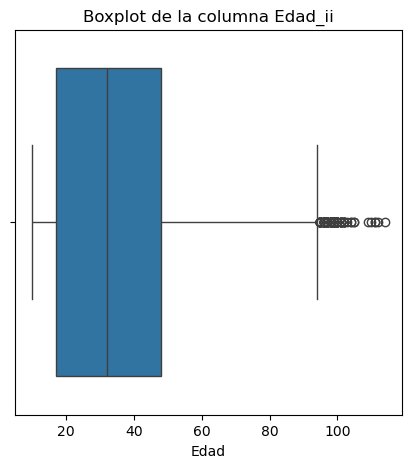

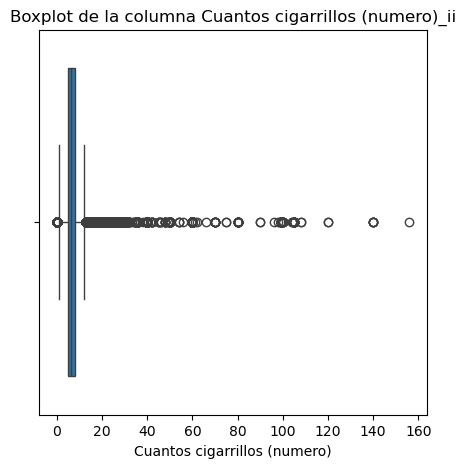

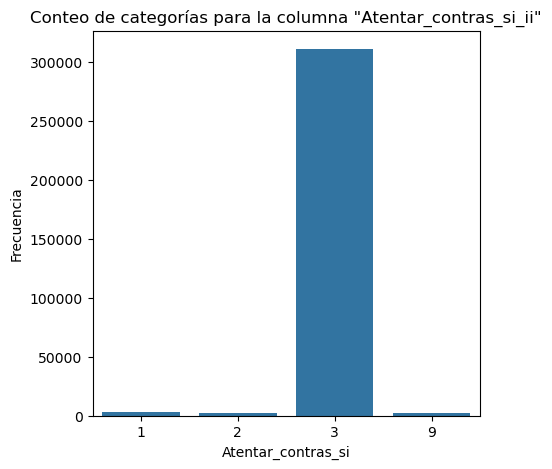

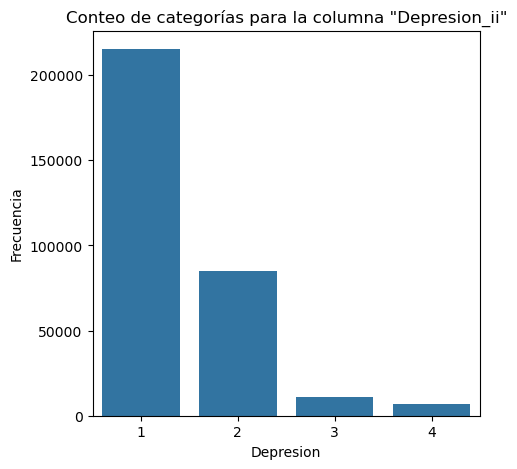

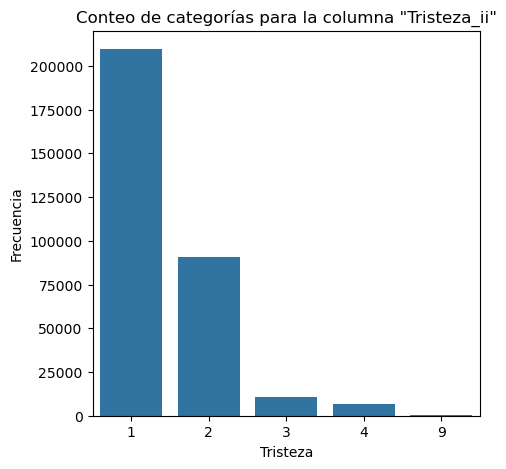

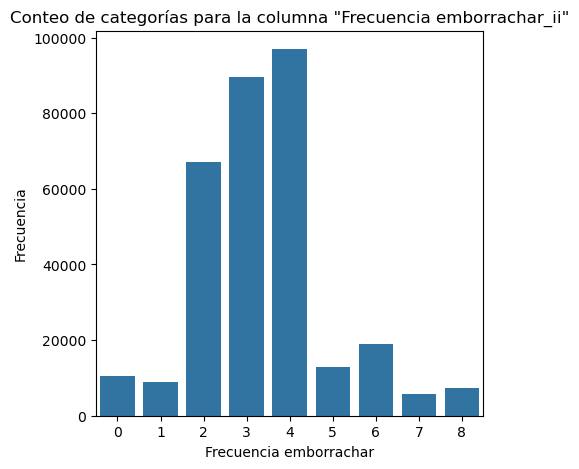

In [271]:
# Boxplot para la columna "Edad"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Edad_ii'])
plt.title('Boxplot de la columna Edad_ii')
plt.xlabel('Edad')
plt.show()

# Boxplot para la columna "Cuantos cigarrillos (numero)"
plt.figure(figsize=(5, 5))
sns.boxplot(x=df['Cuantos cigarrillos (numero)_ii'])
plt.title('Boxplot de la columna Cuantos cigarrillos (numero)_ii')
plt.xlabel('Cuantos cigarrillos (numero)')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Atentar_contras_si_ii')
plt.title('Conteo de categorías para la columna "Atentar_contras_si_ii"')
plt.xlabel('Atentar_contras_si')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Depresion_ii')
plt.title('Conteo de categorías para la columna "Depresion_ii"')
plt.xlabel('Depresion')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Tristeza_ii')
plt.title('Conteo de categorías para la columna "Tristeza_ii"')
plt.xlabel('Tristeza')
plt.ylabel('Frecuencia')
plt.show()

# Conteo de categorías (Countplot) para una columna categórica
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='Frecuencia emborrachar_ii')
plt.title('Conteo de categorías para la columna "Frecuencia emborrachar_ii"')
plt.xlabel('Frecuencia emborrachar')
plt.ylabel('Frecuencia')
plt.show()

We print some basic statistics to see that there is not so much variation:

In [272]:
df.describe()

,Edad,C_Entidad,Fecha,Cuantos cigarrillos (numero),Edad_ii,Cuantos cigarrillos (numero)_ii,Fecha_ii
count,318243.000000,318268.000000,318253,46464.0,318268.000000,318268.000000,318268
mean,34.785321,16.538911,2011-06-06 16:05:03.064543232,6.770855,34.785376,6.635103,2011-06-06 11:23:34.943381504
min,10.000000,1.000000,1999-01-10 00:00:00,0.0,10.000000,0.000000,1999-01-10 00:00:00
25%,17.000000,9.000000,2006-07-31 00:00:00,2.0,17.000000,5.000000,2006-07-31 00:00:00
50%,32.000000,16.000000,2012-07-31 00:00:00,3.0,32.000000,6.000000,2012-07-31 00:00:00
75%,48.000000,24.000000,2018-07-31 00:00:00,8.0,48.000000,8.000000,2018-07-31 00:00:00
max,114.000000,32.000000,2023-11-23 00:00:00,156.0,114.000000,156.000000,2023-11-23 00:00:00
std,19.477638,9.058555,NaN,9.396037,19.476907,4.718272,NaN


We can see that our new columns do not have missing data:

<Axes: >

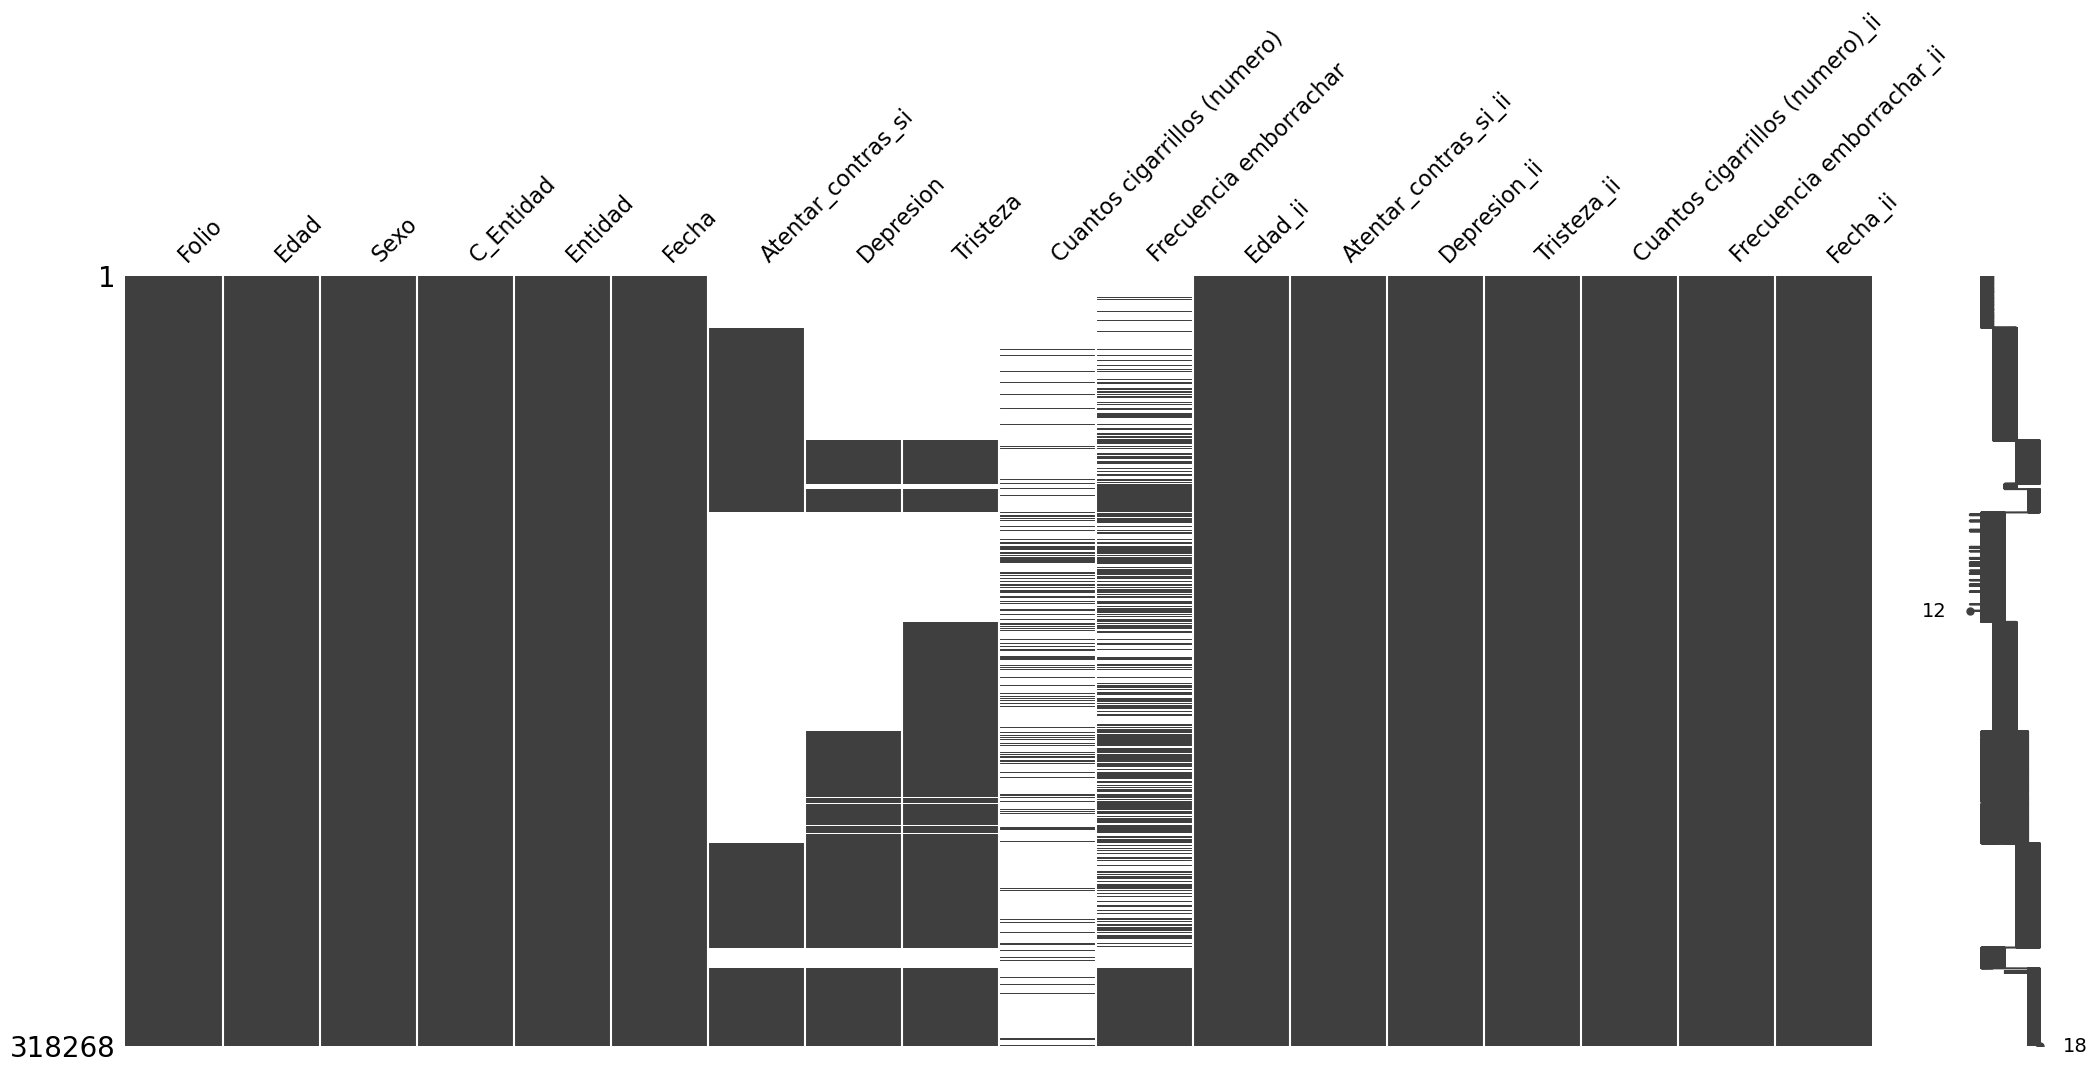

In [273]:
msno.matrix(df)

Finally we can save to get a Ydata and a printout of our data info:

In [274]:
# Para guardar
path_save = os.path.join('..','data', 'processed', 'Ensanut-data-processed.csv')
path_save_parquet = os.path.join('..','data', 'processed', 'Ensanut-data-processed.parquet')
df.to_csv(path_save, index=False)
df.to_parquet(path_save_parquet)
# Para generar el reporte
ruta_output_y = os.path.join('..','docs', 'docs', 'processed-MH-data.html')
title = "ENSANUT YData Profiling Report processed"
# Ydata
df = pd.read_parquet(path_save_parquet)
profile_ensa_ydata = ProfileReport(df, title=title, explorative=True, minimal = True)
profile_ensa_ydata.to_file(ruta_output_y)
print(f"YData report save: {ruta_output_y}")
# Data info
data_info_post_conversion = df.info()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

YData report save: ..\docs\docs\processed-MH-data.html
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318268 entries, 0 to 318267
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Folio                            318268 non-null  object        
 1   Edad                             318243 non-null  float64       
 2   Sexo                             318268 non-null  int64         
 3   C_Entidad                        318268 non-null  int64         
 4   Entidad                          318268 non-null  object        
 5   Fecha                            318253 non-null  datetime64[ns]
 6   Atentar_contras_si               151918 non-null  category      
 7   Depresion                        147755 non-null  category      
 8   Tristeza                         192996 non-null  category      
 9   Cuantos cigarrillos (numero)     46464 non-null   Int64    